# Agent-Based Model - General Paz

## Descripción del modelo

### Objetivo

Nuestro objetivo es implementar una simulación realista de la Avenida General Paz. En los tramos de Liniers a Lugones. 

### Entidades / Agentes

Las entidades del modelo, qué serán los qué circulen por él, en nuestro modelo corresponden a los automóviles con sus respectivos conductores. Los agentes son autónomos, es decir, están dotados con comportamientos que les permiten tomar decisiones independientes.

### Atributos

Las entidades tienen distintos atributos que lo describen como:

- Posición **(x)**.
- Velocidad **(v)**.
- Velocidad máxima del vehículo **(vmax)**.
- Longitud del auto. **(l)**.
- Aceleración y desaceleración (cuanto tarda el vehículo en promedio en llegar de 0 a 80 y de 80 a 0 km/h) **(a)**.
- Tiempo de permanencia en la autopista **(t)**.
- Tiempo de reacción de frenado. **(tr)**

##### Interacción con otros agentes
Cada agente tiene un vehiculo por detras y por delante. Del vehiculo de adelante dependerá si el agente frena o no. Las reducciones de velocidad son las que causarán los *shockwaves*. 

- Distancia entre vehículo de atras **(bd)**.
- Distancia entre vehiculo de adelante **(fd)**. 

##### Comportamiento
- Los agentes reaccionan (mantienen su velocidad, aceleran y desaceleran) dependiendo de el ambiente y su vecindario. 
- Un agente podrá acelerar/desacelerar si el auto de adelante se lo permite. 
- Dependiendo de el comportamiento del agente que maneje el vehiculo, el mismo:
  -  respetará los limites de velocidad o no.
  -   tendrá mas o menos probabilidad de choque.


### Ambiente

El ambiente de nuestro agent-based transportation model será la infraestructura y capacidades de los nodos y enlaces de la red vial. Estas capacidades crean efectos de congestión (velocidades de viaje reducidas) limitando el número de agentes que se desplazan a través de la red de transporte en un momento dado.

### Variables de Decisión

Las variables de decisión son las qué generarán distintas alternativas o escenarios en el modelo. Es decir, estas serán las qué ayudarán a determinar cuál es el layout óptimo para la solución.
- Agregar peaje o no
- Agregar semáforos y cuantos.
- Agregar cámaras de fotomultas y cuantas.

### Variables de Referencia:  

Las variables de referencia son las obtenidas cómo resultado de la simulación. Se buscará mejorarlas en función al objetivo.
Tiempo promedio de recorrido de los vehículos.

### Variables de Estado

Las variables de estado son aquellas qué contienen la información necesaria para describir la situación actual de los recursos.
- Tasa de Ocupación en las principales zonas de aglomeración.
- Tasa de ocupación ocasionada por accidentes, vehículos detenidos, obras en la ruta, policías parando, etc.
- Tasa de ocupación ocasionada por mal tiempo.
- Tasa de ocupación del peaje o semáforos  (si es que se agregan).

### Recursos

- Los recursos utilizados en el modelo son:
- Las cámaras
- Los peajes 
- Los carteles de velocidad / Avisos. 

### Distribuciones

#### Distribución de arribos de vehiculos

Optado por la utilización de una *distribución exponencial negativa* como modelo para representar los arribos de vehículos, y esta elección se fundamenta en diversas consideraciones clave.

La distribución exponencial negativa es una selección frecuentemente empleada en la modelación de procesos de llegada aleatoria. En el contexto de rutas de vehículos, esta distribución se ajusta adecuadamente cuando se asume que los arribos de vehículos son eventos independientes y se producen a una tasa constante a lo largo del tiempo. En otras palabras, la probabilidad de que un vehículo llegue en un periodo determinado es constante y no depende del momento en que llegaron los vehículos previos.

Sin embargo, es fundamental destacar que emplearemos parámetros diferentes para la distribución, dependiendo de la franja horaria en la que nos encontremos, ya sea durante las horas pico o en otros momentos del día.

La distribución que elegiremos para modelar los arribos será la siguiente:
$$f(x | \lambda) = e^{(-\lambda x)}$$

$$
\lambda =
\begin{cases}
\frac{1}{\mu_1} = \frac{1}{15 \text{s}} \, & \text{si es hora pico} \\
\frac{1}{\mu_2} = \frac{1}{45 \text{s}}, & \text{si no es hora pico}
\end{cases}
$$

#### Distribución de velocidad

La distribución triangular es una elección adecuada para simular la velocidad de los autos en una ruta con un mínimo de 30 km/h, una moda de 70 km/h y un máximo de 100 km/h por lo siguiente:

Es una distribución continua que permite modelar situaciones en las que existe un valor mínimo, un valor máximo y un valor modal. En el contexto de la velocidad de los autos en una carretera, es razonable suponer que la mayoría de los autos se moverán a una velocidad cercana a la moda (70 km/h) y que habrá algunos que irán más rápido o más lento. Esto se ajusta bien a la forma de la distribución triangular.

$$
f(x) = \begin{cases}
0 & \text{si } x < 30 \\
\frac{2(x-30)}{(70-30)(100-30)} & \text{si } 30 \leq x < 70 \\
\frac{2(70-x)}{(70-30)(70-100)} & \text{si } 100 \leq x \leq 70 \\
0 & \text{si } x > 100
\end{cases}
$$

#### Distribución de variación de velocidad

En nuestra simulación de la Gral. Paz, cada agente se comporta de manera única y puede variar en su velocidad debido a diferentes factores, como la relación con otros agentes y las condiciones del entorno. Para modelar esta variación de velocidad, inicialmente utilizamos la distribución triangular, que nos proporciona una velocidad modal estimada para cada agente.

Sin embargo, sabemos que los agentes no mantendrán una velocidad constante en la carretera, ya que pueden optar por no respetar las leyes de velocidad, frenar de manera abrupta o ajustar su velocidad de acuerdo con la situación. Por lo tanto, para capturar esta variabilidad en la velocidad de manera más realista, decidimos emplear la distribución normal.

La distribución normal se seleccionó como una opción apropiada para modelar la variación de velocidad de los agentes debido a sus ventajas. Esta distribución es ampliamente reconocida por su capacidad para representar la variabilidad en datos del mundo real. Además, su simetría y versatilidad permiten modelar la idea de que algunos agentes pueden conducir a velocidades más altas o más bajas que la velocidad modal, mientras que la mayoría se mantendrá cerca de esta velocidad central.

La distribución normal también se ajusta fácilmente mediante la variación de la varianza, lo que nos permite controlar el grado de variación en las velocidades de los agentes de acuerdo con las necesidades de nuestra simulación.

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

$$
\begin{align*}
\mu & \text{ es la velocidad del agente obtenida a partir de la distribución triangular}, \\
\sigma & = 5 \text{ km/h} \text{ (varianza)}.
\end{align*}
$$


#### Distribución de frenado

Elegimos la *distribución exponencial* como modelo para la fuerza de frenado de los vehículos en función de su proximidad al vehículo de adelante debido a varias razones fundamentales:

1. **Falta de Memoria a Largo Plazo:** Esta propiedad implica que la probabilidad de que un vehículo frene con fuerza en un momento dado no depende de cuánto tiempo haya transcurrido desde el último frenado. En otras palabras, cada vehículo toma decisiones de frenado independientes en función de su proximidad actual al vehículo de adelante. Esta falta de dependencia temporal es esencial para capturar situaciones realistas en el tráfico, donde los eventos de frenado ocurren de manera estocástica y no están vinculados a eventos previos.

2. **Ajuste de la "Agresividad" del Frenado:** La distribución exponencial nos brinda la flexibilidad de ajustar el grado de "agresividad" en el frenado de los vehículos a través del parámetro de tasa (λ). Al variar el valor de λ, podemos modelar diferentes comportamientos de frenado. Un valor más alto de λ indica que los vehículos son menos propensos a frenar con fuerza cuando están cerca del vehículo de adelante, lo que podría representar situaciones de tráfico más fluidas. Por otro lado, un valor más bajo de λ indica una mayor probabilidad de frenado en distancias cercanas, lo que podría reflejar situaciones de tráfico más congestionadas o conductores más cautelosos.

3. **Modelización de Eventos Independientes:** La distribución exponencial es ampliamente utilizada para modelar eventos aleatorios que ocurren de manera independiente a lo largo del tiempo. En el contexto del tráfico, asumimos que los frenados de los vehículos son eventos estocásticos e independientes, ya que las decisiones de frenado de un vehículo no están influenciadas por los eventos de frenado de otros vehículos en el pasado. Esta suposición es coherente con la variabilidad inherente a las interacciones de tráfico en situaciones reales.

La formula que utilizaremos será la siguiente:
$$f(x | \lambda) = 1 - e^{(-\lambda x)}$$

$$
\lambda =
\begin{cases}
\frac{1}{\mu_1} = \frac{1}{1s}, & \text{ si } \text{dist\_to\_front\_agent()} ≤ 10 \text{m} \\
\frac{1}{\mu_2} = \frac{1}{3s}, & \text{ si } \text{dist\_to\_front\_agent()} > 10 \text{m}
\end{cases}
$$



#### Distribución del tiempo de reacción del agente

Elegimos la *distribución normal* para simular el tiempo de reacción debido a su capacidad para representar la variabilidad realista en los tiempos de reacción de las personas al frenar. La distribución normal se ajusta bien a situaciones en las que la mayoría de los individuos tienen tiempos de reacción cercanos a un valor promedio (la media), con menos personas que experimentan tiempos de reacción significativamente más cortos o más largos. Esto refleja con precisión cómo la mayoría de las personas conducen con tiempos de reacción similares, pero aún existe variabilidad natural. 

Luego de una busqueda de estudios de investigación acerca del comportamiento de los conductores en la autopista Gral. Paz y otras autopistas de Buenos Aires, encontramos que la media de el tiempo de reacción se aproxima a 1s con un desvio de 0.2s.

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

$$
\begin{align*}
\mu & = 1s \\
\sigma & = 0.2s
\end{align*}
$$

## Simulación

In [151]:
import random 
from typing import Optional
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [152]:
exponencialnegativa = stats.expon()

In [153]:
class Agent:

    def __init__(
        self, 
        x:float,                                                      #posición                                                                                                  
        vmax:float,                                                   #velocidad máxima
        l:float,                                                      #longitud del vehiculo
        a:float,                                                      #aceleración
        fa: Optional["Agent"] = None,                                 #agente de adelante
        ba: Optional["Agent"] = None,                                 #agente de atras
        at:int = 0,                                                   #tiempo de entrada a la autopista
    ):
    
        self.position = x
        self.max_velocity = vmax
        self.length = l
        self.aceleration = a
        self.front_agent = fa
        self.back_agent = ba
        self.arrival_time = at

        '''
        velocidad de agente es generada a partir de la distribución triangular con los siguientes parametros:
        - 30,000 m/s: velocidad minima
        - 100,000 m/s: velocidad maxima
        - 70,000 m/s: moda
        '''
        self.velocity = random.triangular(30000, 100000, 70000)
        self.time = 0
    
        self.reaction_time = random.normalvariate(1, 0.2) 
    
    def __str__(self):
        return f"Agent(t={self.time}, x={self.position}, v={self.velocity}, vmax={self.max_velocity}, l={self.length}, a={self.aceleration}, rt={self.reaction_time}, fa={self.front_agent}, ba={self.back_agent}, at={self.arrival_time})"
    

    def dist_to_front_agent(self):
        if self.front_agent == None:
            return None

        else: #hay otro agente adelante
            return abs(self.position - self.front_agent.position - self.length)


    def dist_to_back_agent(self):
        if self.back_agent == None:
            return None

        else: #hay otro agent atras
            return abs(self.back_agent.position - self.position - self.back_agent.length)

    def speed_variation(self):

        if self.dist_to_front_agent() == None or self.dist_to_front_agent() >= 20:
            self.velocity = random.normalvariate(self.velocity, 50000)


    def reduce_speed(self):
        # si se encuentra "cerca" del agente de adelante, reducirá su velocidad mediante una distribución exponencial con media 1.
        if self.dist_to_front_agent() != None and self.dist_to_front_agent() < 10:
            self.velocity -= (self.velocity - self.front_agent.velocity) / (1 - stats.expon().rvs(1)) # La velocidad que tenes que reducir por segundo.

         # si se encuentra "lejos" del agente de adelante, reducirá su velocidad mediante una distribución exponencial con media 3.
        elif self.dist_to_front_agent() != None and self.dist_to_front_agent() >= 10 and self.dist_to_front_agent() <= 20:
            self.velocity -= (self.velocity - self.front_agent.velocity) / (1 - stats.expon().rvs(3))

        # si no tine agente adelante seguira a la misma velocidad que tenia.
        else:
            self.velocity = self.velocity


    def move(self):
        self.position = self.position + self.velocity * 1 
    
    def update_position(self):
        return self.position

    def update(self):
        self.move()
        self.reduce_speed()
        self.speed_variation()
        self.update_position()
        self.time += 1


In [154]:
class Road:
    
    def __init__(self, km:int, c:bool):
        self.km = km
        self.agents = []
        self.time = 0
        self.total_time = 10
        self.congestion = c
        self.time_to_next_arrival = 0

    def __repr__(self):
        return f"Road(km={self.km}, agents={self.agents}, t={self.time})"
    
    def add_agent(self, rate, agent:Agent):
        print(self.time)
        print(self.agents)

        # Si no hay agentes en la Gral.Paz, agregamos el primer agente
        if len(self.agents) == 0:
            self.agents.append(agent)
            agent.front_agent = None
            agent.back_agent = None
            agent.arrival_time = self.time
            self.time_to_next_arrival = stats.expon.rvs(scale=1/rate)

        # Si hay agentes en Gral.Paz, agregaremos un nuevo agente con distribución exponencial negativa
        else:
            if self.time - self.agents[-1].arrival_time > self.time_to_next_arrival:
                self.agents.append(agent)
                agent.position = 0
                agent.arrival_time = self.time
                self.time_to_next_arrival = stats.expon.rvs(scale=1/rate)


                #asignamos su front y su back car teniendo en cuenta la lista de self.agents
                if len(self.agents) >= 2:
                    agent.front_agent = self.agents[-2]
                    self.agents[-2].back_agent = agent
        
        print(self.agents)
        self.update()

    def time_lapse(self):
        while self.time < self.total_time:
            if self.congestion == True:
                # Agrega autos con distribución exponencial negativa con media = 15
                for agent in self.agents:
                    self.add_agent(15, agent)
            else:
                # Agrega autos con distribución exponencial negativa con media = 45
                for agent in self.agents:
                    self.add_agent(45, agent)
        
    
    def update(self):
        for agent in self.agents:
            agent.update()
            print(agent.position)
            #si el agente llega al final de la carretera lo eliminamos
            if agent.position > self.km:
                self.agents.remove(agent)

            #asignamos el front y back car de los agentes extremos de la lista
            if len(self.agents) > 0:
                self.agents[0].front_agent = None

        self.time += 1
        self.time_lapse()
    

        
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot([agent.position for agent in self.agents], [0 for agent in self.agents], "o")
        ax.set_xlim(0, self.km)
        ax.set_ylim(-1, 1)
        ax.set_yticks([])
        ax.set_xlabel("Position")
        ax.set_title("Highway")
        ax.legend()
        
        plt.show()

In [155]:
agp = Road(km = 100000, c = False)

# Crear una instancia de Agent
agent1 = Agent(x=0, vmax=120, l=5, a=2, fa=None, ba=None, at=0)

# Agregar el agente a la carretera
agp.add_agent(15, agent1)  # Opcionalmente, puedes usar la tasa (rate) deseada aquí

0
[]
63019.62790819394
1
[<__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>]
123757.89219717003
[247515.78439434]
2
[<__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>]
[<__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>]
[116628.93924401]
[233257.87848802]
[313759.8219067]
3
[<__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>]
[<__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>]
[92087.9238153]
[184175.8476306]
[294125.68422442]
[427103.21396011]
4
[<__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>, <__main__.Agent object at 0x0000023D444D6A30>, <__ma

No handles with labels found to put in legend.


[1668521.47274983]
[2207719.64707534]


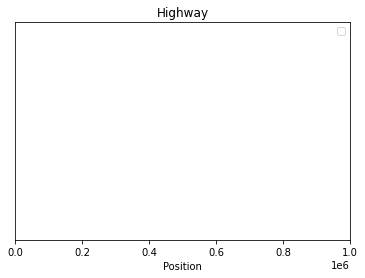

In [156]:
for i in range(2):
    agp.update()
agp.plot()